## SOFI 2D Model Builder
- This code shows an interactive and step-by-step code to generate 2D models ready to run in SOFI2D
- Structures and examples are focused on acoustic well-logging applications
- Currently, only vertical or horizontal features can be incorporated in the model

##### Reference:
I used - SOFI 2D - User Guide written by Thomas Bohlen, Denise De Nil, Daniel Kohn and Stefan Jetschny

Link: https://git.scc.kit.edu/GPIAG-Software/SOFI2D/-/wikis/home


#### Imported Libraries

In [100]:
import os                                                 # to set current working directory 
import math                                               # basic calculations like square root
import numpy as np                                        # arrays and matrix math
import matplotlib.pyplot as plt                           # plotting
import pandas as pd
import struct
from scipy.fft import fft, fftfreq, fftshift

#### Functions
References used binary-float32 data transformations:
https://docs.python.org/3/library/struct.html#examples
https://www.stackvidhya.com/python-read-binary-file/
https://pythonguides.com/python-read-a-binary-file/
https://www.bestprog.net/en/2020/04/30/python-binary-files-examples-of-working-with-binary-files/#:~:text=Python%20has%20tools%20for%20working%20with%20binary%20files.,function%2C%20whose%20mode%20parameter%20contains%20the%20character%20%E2%80%98b%E2%80%99

In [101]:
#Source:
#https://gist.github.com/LyleScott/e36e08bfb23b1f87af68c9051f985302#:~:text=Rotate%20X%2CY%20%282D%29%20coordinates%20around%20a%20point%20or,0%29.%22%22%22.%20%22%22%22Rotate%20a%20point%20around%20a%20given%20point.
def rotate_around_point_highperf(xy, radians, origin=(0, 0)):
    """Rotate a point around a given point.
    
    I call this the "high performance" version since we're caching some
    values that are needed >1 time. It's less readable than the previous
    function but it's faster.
    """
    x, y = xy
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = math.cos(radians)
    sin_rad = math.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y

    return qx, qy

def plotmodels(xx_grid,yy_grid,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs):
    plt.subplot(2,3,1)
    im1 = plt.contourf(xx_grid, yy_grid, zz_Vp,500,cmap=plt.cm.jet,norm=None)
    plt.title('P-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im1, orientation = 'vertical')
    cbar.set_label("P-wave velocity (m/s)")

    plt.subplot(2,3,2)
    im2 = plt.contourf(xx_grid, yy_grid, zz_Vs,500,cmap=plt.cm.jet,norm=None)
    plt.title('S-wave model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im2, orientation = 'vertical')
    cbar.set_label("S-wave velocity (m/s)")

    plt.subplot(2,3,3)
    im3 = plt.contourf(xx_grid, yy_grid, zz_Rho,500,cmap=plt.cm.jet,norm=None)
    plt.title('Density model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im3, orientation = 'vertical')
    cbar.set_label("Density (kg/m^3)")

    plt.subplot(2,3,4)
    im4 = plt.contourf(xx_grid, yy_grid, zz_Qp,500,cmap=plt.cm.jet,norm=None)
    plt.title('P-wave attenuation model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im4, orientation = 'vertical')
    cbar.set_label("P-wave attenuation")

    plt.subplot(2,3,5)
    im5 = plt.contourf(xx_grid, yy_grid, zz_Qs,500,cmap=plt.cm.jet,norm=None)
    plt.title('S-wave attenuation model')
    plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
    cbar = plt.colorbar(im5, orientation = 'vertical')
    cbar.set_label("S-wave attenuation")

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3, wspace=0.2, hspace=0.2)

def HorizontalLayer(NX,NY,dh,zz_base,Top,Thickness,zz_new):
    xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
    xx_m=xx_grid*dh
    yy_m=yy_grid*dh
    for x in range(NY):
        for y in range(NX):
            if yy_m[x,y]>=Top and yy_m[x,y]<=(Top+Thickness):
                zz_base[y,x]=zz_new
    return zz_base

def DippingLayer(NX,NY,dh,zz_base,Top,Top_x_reference,Angle_deg,Thickness,zz_new):
    xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
    xx_m=xx_grid*dh
    yy_m=yy_grid*dh
    for x in range(NY):
        for y in range(NX):
            xy=(xx_m[x,y],yy_m[x,y])
            origin=(Top_x_reference,Top)
            radians=Angle_deg*math.pi/180
            [xx_m[x,y],yy_m[x,y]]=rotate_around_point_highperf(xy, radians, origin)
            if yy_m[x,y]>=Top and yy_m[x,y]<=(Top+Thickness):
                zz_base[y,x]=zz_new
    return zz_base

def VerticalLayer(NX,NY,dh,zz_base,From,To,zz_new):
    xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
    xx_m=xx_grid*dh
    yy_m=yy_grid*dh
    for x in range(NY):
        for y in range(NX):
            if xx_m[x,y]>=From and xx_m[x,y]<=(To):
                zz_base[y,x]=zz_new
    return zz_base

def Placement_HorizontalLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh,Top,Thickness,Vp,Vs,Rho,Qp,Qs):
    zz_Vp=HorizontalLayer(NX,NY,dh,zz_Vp,Top,Thickness,Vp)
    zz_Vs=HorizontalLayer(NX,NY,dh,zz_Vs,Top,Thickness,Vs)
    zz_Rho=HorizontalLayer(NX,NY,dh,zz_Rho,Top,Thickness,Rho)
    zz_Qp=HorizontalLayer(NX,NY,dh,zz_Qp,Top,Thickness,Qp)
    zz_Qs=HorizontalLayer(NX,NY,dh,zz_Qs,Top,Thickness,Qs)
    return zz_Vp, zz_Vs, zz_Rho, zz_Qp, zz_Qs

def Placement_DippingLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh,Top,Top_x_reference,Angle_deg,Thickness,Vp,Vs,Rho,Qp,Qs):
    zz_Vp=DippingLayer(NX,NY,dh,zz_Vp,Top,Top_x_reference,Angle_deg,Thickness,Vp)
    zz_Vs=DippingLayer(NX,NY,dh,zz_Vs,Top,Top_x_reference,Angle_deg,Thickness,Vs)
    zz_Rho=DippingLayer(NX,NY,dh,zz_Rho,Top,Top_x_reference,Angle_deg,Thickness,Rho)
    zz_Qp=DippingLayer(NX,NY,dh,zz_Qp,Top,Top_x_reference,Angle_deg,Thickness,Qp)
    zz_Qs=DippingLayer(NX,NY,dh,zz_Qs,Top,Top_x_reference,Angle_deg,Thickness,Qs)
    return zz_Vp, zz_Vs, zz_Rho, zz_Qp, zz_Qs

def Placement_VerticallLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh,From,To,Vp,Vs,Rho,Qp,Qs):
    zz_Vp=VerticalLayer(NX,NY,dh,zz_Vp,From,To,Vp)
    zz_Vs=VerticalLayer(NX,NY,dh,zz_Vs,From,To,Vs)
    zz_Rho=VerticalLayer(NX,NY,dh,zz_Rho,From,To,Rho)
    zz_Qp=VerticalLayer(NX,NY,dh,zz_Qp,From,To,Qp)
    zz_Qs=VerticalLayer(NX,NY,dh,zz_Qs,From,To,Qs)
    return zz_Vp, zz_Vs, zz_Rho, zz_Qp, zz_Qs

def openfile_frombinarytofloat32array(filename,nx_file,ny_file):
    newfile=open(filename,"rb")
    filecontent=newfile.readline()
    datasize=struct.calcsize('f')
    contentsize=len(filecontent)/datasize
    if nx_file*ny_file==contentsize:
        print('File size is correct')
        data = np.zeros([nx_file,ny_file])
        count=0
        for n in range(nx_file):
            for m in range(ny_file):
                data[n,m] = struct.unpack('f',filecontent[count:count+4])[0]
                count=count+4
    else:
        data=[]
        print('File size is NOT correct')
        print(nx_file*ny_file)
        print(contentsize)
    return data

def savefile_fromfloat32arraytobinary(filename,nx_file,ny_file,array):
    newfile=open(filename,"wb")
    for n in range(nx_file):
        for m in range(ny_file):
            output_binary=struct.pack('f',array[n,m])
            newfile.write(output_binary)
            
def LinearArray(x_start,x_end,y_start,y_end,spacing):
    ArrayLength=np.sqrt((x_end-x_start)**2+(y_end-y_start)**2)
    if x_end==x_start:
        ArrayAngle=np.pi/2
    else:
        ArrayAngle=math.atan((y_end-y_start)/(x_end-x_start))
    ArraySize=int(ArrayLength/spacing)
    if ArraySize<=1:
        Array=np.zeros([1,2])
        Array[0,0]=x_start
        Array[0,1]=y_start
    else:
        Array=np.zeros([ArraySize,2])
        for n in range(ArraySize):
            Array[n,0]=x_start+n*spacing*np.cos(ArrayAngle)
            Array[n,1]=y_start+n*spacing*np.sin(ArrayAngle)
    return Array

def TRplacement(GridSize,Gridref_x,Gridref_y,Input):               #this function transforms a set of coordinates into an array of coordinates for source/receiver placement
    function_grid=np.zeros([len(Input),2])
    for n in range(len(Input)):                                     #transform from coordinate to grid points
        function_grid[n,0]=int((Input[n,0]-Gridref_x)/GridSize)
        function_grid[n,1]=int((Input[n,1]-Gridref_y)/GridSize)
    #Clean duplicate values
    temp=np.ones(np.shape(function_grid))*np.nan                   #Create a vector the same size as the input, this is the non-duplicate list
    temp[0,:]=function_grid[0,:]
    count=1
    index=0
    for n in range(len(function_grid)):                            #Take one by one the transformed values...
        flag=0
        for m in range(count):                                     #...and compare them against the non-duplicate list
            if flag==0:
                if function_grid[n,0]==temp[m,0] and function_grid[n,1]==temp[m,1]:
                    flag=1
        if flag==0:                                                #if an 'n' value wasnt found in the non-duplicate vector list...
            count=count+1                                          #...then it is added as a new component
            temp[count-1,:]=function_grid[n,:]
    function_gridded=temp[0:count,:]                               #we uppdate the size of the output to the total of non-duplicated values
    function_gridded_m=function_gridded*0
    for n in range(len(function_gridded)):
        function_gridded_m[n,0]=(function_gridded[n,0]*GridSize+Gridref_x)
        function_gridded_m[n,1]=(function_gridded[n,1]*GridSize+Gridref_y)    
    return function_gridded_m

def TRcornercleaning(function_gridded):                            #this function cleans up corners generated by the TRPlacement function
    temp=np.ones(np.shape(function_gridded))*np.nan
    temp[0,:]=function_gridded[0,:]
    count=1
    for n in range(1,len(function_gridded)-1):
        if function_gridded[n,0]==function_gridded[n-1,0] and function_gridded[n,1]==function_gridded[n+1,1]:
            count=count
        else:
            count=count+1
            temp[count-1,:]=function_gridded[n,:]
    temp[count,:]=function_gridded[len(function_gridded)-1,:]
    function_gridded_clean=temp[0:count+1,:]
    return function_gridded_clean

### 1. Defining the grid
Optimal grid dimensions definition requires knowledge of:
- Maximum and minimum velocities
- Maximum frequency

These two set of parameters give recommended grid size $dh$ and time step $DT$
After that, knowledge of model dimensions is required:
- X-Y Dimensions
- Modeling time span

These second set of parameters are in charge of defining total number of steps $NT$ and grid dimension $NX$ and $NY$


In [102]:
#Model Parameters
ModelMaxVel=5860                    #Maximum velocity (in m/s)
ModelMinVel=1000                    #Minimum velocity (in m/s)
PeakFrequency=2000
MaxFrequency=2*PeakFrequency                  #Maximum frequency required (in Hz) -> two times center frequency

n_Taylor=[12,8,6,5,5,4]                                                  #Spatial Taylor coefficients (unitless)
dh_Taylor=np.zeros(len(n_Taylor))
h_Taylor_N2=[1,7/6,149/120,2161/1680,53089/40320,1187803/887040]            #Time Taylor coefficients (unitless)
dt_Taylor=np.zeros([len(n_Taylor),2])
#I generate a dataframe with dh and dt values using Taylor coefficients
for n in range(len(n_Taylor)):
    dh_Taylor[n]=ModelMinVel/(n_Taylor[n]*MaxFrequency)
    dt_Taylor[n,0]=dh_Taylor[n]/(h_Taylor_N2[n]*np.sqrt(2)*ModelMaxVel)
    dt_Taylor[n,1]=6*dh_Taylor[n]/(7*h_Taylor_N2[n]*np.sqrt(2)*ModelMaxVel)
d={'n_Taylor':n_Taylor,'dh (m)':dh_Taylor,'h_M2':h_Taylor_N2}
df_grid_Taylor = pd.DataFrame(data=d)

for n in range(2):
    df_grid_Taylor['M_'+str(2*(1+n))+' (s)']=dt_Taylor[:,n]

    
df_grid_Taylor.head(n=len(n_Taylor))    

,n_Taylor,dh (m),h_M2,M_2 (s),M_4 (s)
0,12,0.020833,1.000000,0.000003,0.000002
1,8,0.031250,1.166667,0.000003,0.000003
2,6,0.041667,1.241667,0.000004,0.000003
3,5,0.050000,1.286310,0.000005,0.000004
4,5,0.050000,1.316691,0.000005,0.000004
5,4,0.062500,1.339064,0.000006,0.000005


In [103]:
#I generate a dataframe with dh and dt values using Holberg coefficients
n_Holberg=[12,8.32,4.77,3.69,3.19,2.91]
dh_Holberg=np.zeros(len(n_Holberg))
h_Holberg_N2=[1,1.1846146,1.283482,1.345927,1.387660,1.417065]
dt_Holberg=np.zeros([len(n_Holberg),2])
for n in range(len(n_Holberg)):
    dh_Holberg[n]=ModelMinVel/(2*n_Holberg[n]*MaxFrequency)
    dt_Holberg[n,0]=dh_Holberg[n]/(h_Holberg_N2[n]*np.sqrt(3)*ModelMaxVel)
    dt_Holberg[n,1]=6*dh_Holberg[n]/(7*h_Holberg_N2[n]*np.sqrt(3)*ModelMaxVel)
d={'n_Holberg':n_Holberg,'dh (m)':dh_Holberg,'h':h_Holberg_N2}
df_grid_Holberg = pd.DataFrame(data=d)

for n in range(2):
    df_grid_Holberg['N_'+str(2*(1+n))+' (s)']=dt_Holberg[:,n]

    
df_grid_Holberg.head(n=len(n_Holberg))  

,n_Holberg,dh (m),h,N_2 (s),N_4 (s)
0,12.00,0.010417,1.000000,0.000001,8.796780e-07
1,8.32,0.015024,1.184615,0.000001,1.071037e-06
2,4.77,0.026205,1.283482,0.000002,1.724236e-06
3,3.69,0.033875,1.345927,0.000002,2.125480e-06
4,3.19,0.039185,1.387660,0.000003,2.384686e-06
5,2.91,0.042955,1.417065,0.000003,2.559895e-06


In [104]:
#Once I define my dh and dt for the model, I build my grid
# dh_model=np.round(dh_Taylor[0],decimals=5)                            #model grid size (in m)
dh_model=np.round(0.001,decimals=5)                            #model grid size (in m)
dt_model=np.round(dt_Taylor[0,0],decimals=9)                           #time step (in s)
#Then I define the dimensions of the grid
X_length=0.3                                     #grid length along X-direction   (in m)
Y_length=7                                       #grid length along Y-direction   (in m)
T_length=5.5/1000                                        #simulation time                 (in s)
#And then I can create my grid
NX=int(np.round(X_length/dh_model))                    #grid size along X-direction     (number of cells)
NY=int(np.round(Y_length/dh_model))                    #grid size along Y-direction     (number of cells)
NT=int(np.round(T_length/dt_model))                    #Total number of steps

print('Grid has the following dimensions. X:'+str(np.round(NX))+',Y:'+str(np.round(NY))+' and a total of '+str(np.round(NT))+' steps.')
print('Grid spacing is: '+str(dh_model))
print('Time step is: '+str(dt_model))

Grid has the following dimensions. X:300,Y:7000 and a total of 2188 steps.
Grid spacing is: 0.001
Time step is: 2.514e-06


### 2. Defining the model
Once I generate the grid, I generate a base model using a single layer with the initial parametrical values: P-wave model, S-wave model, Density model, P-wave attenuation model and S-wave attenuation model.
- Each layer has a constant value for each parameter
- Every subsequent layer replaces the preexisting value of parameter within the layer grid
- Layer input is done through grid coordinates range and parameters

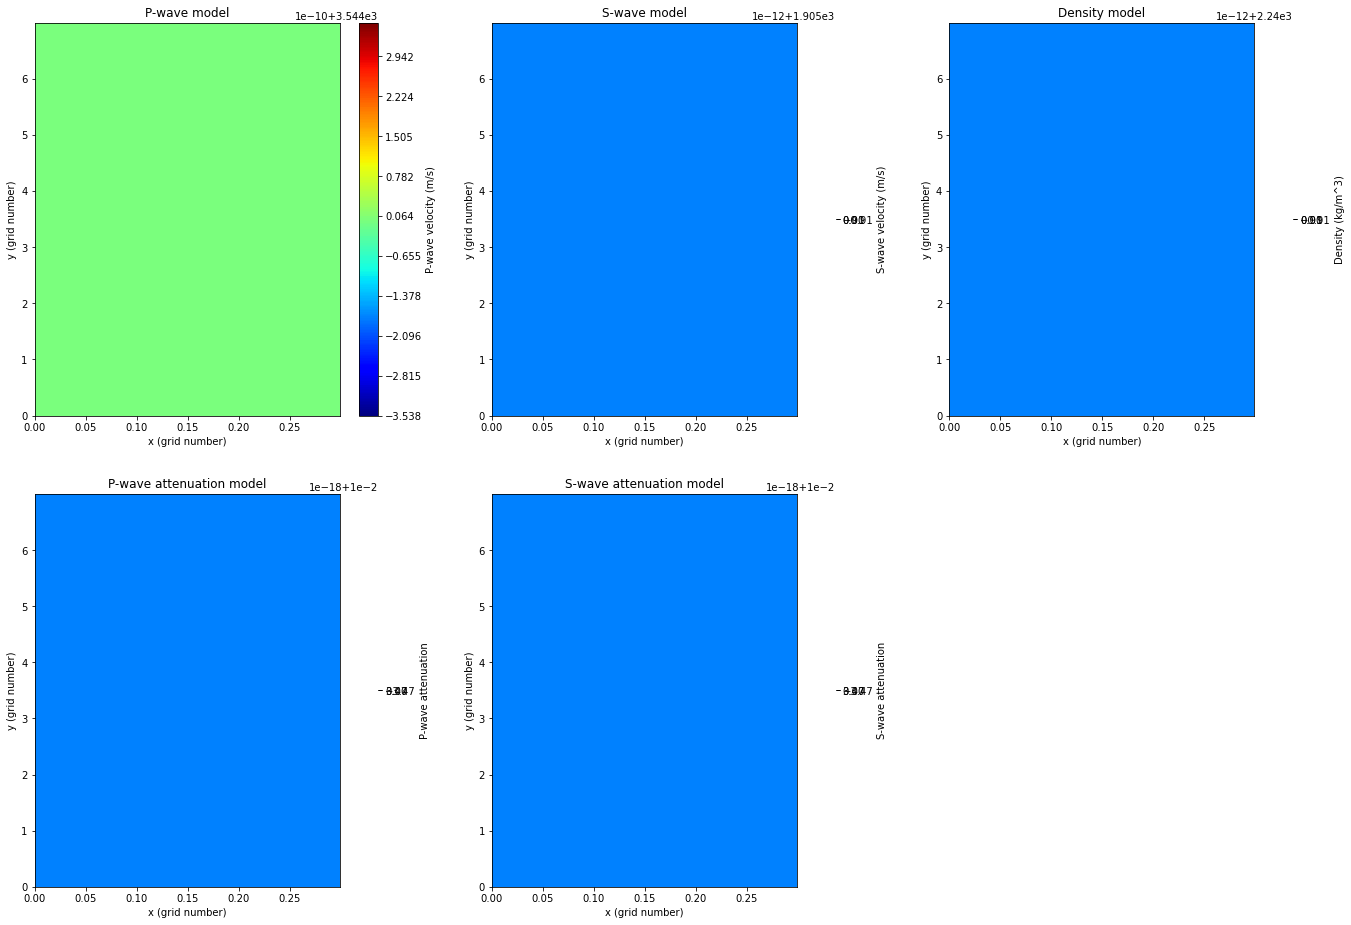

In [105]:
#Base layer
#Define parameters:
#P-wave velocity (m/s)
Vp=3544
#S-wave velocity (m/s)
Vs=1905
#Density (kg/m^3)
Rho=2240
#Vp-wave attenuation (unitless)
Qp=0.01
#Vs-wave attenuation (unitless)
Qs=0.01

#Grid generation and population
xx_grid, yy_grid = np.meshgrid(np.linspace(0,NX-1,NX),np.linspace(0,NY-1,NY))
xx_m=xx_grid*dh_model
yy_m=yy_grid*dh_model
zz_Vp=np.ones([NX,NY])*Vp
zz_Vs=np.ones([NX,NY])*Vs
zz_Rho=np.ones([NX,NY])*Rho
zz_Qp=np.ones([NX,NY])*Qp
zz_Qs=np.ones([NX,NY])*Qs

plotmodels(xx_m.T,yy_m.T,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs)

In [106]:
# #Layer 1
# Top=0
# Thickness=1
# Vp=3000
# Vs=1800
# Rho=2000
# Qp=Qp
# Qs=Qs
# [zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_HorizontalLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,Top,Thickness,Vp,Vs,Rho,Qp,Qs)

# #Layer 2
# Top=1
# Thickness=1.5
# Vp=3500
# Vs=2100
# Rho=2100
# Qp=Qp
# Qs=Qs
# [zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_HorizontalLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,Top,Thickness,Vp,Vs,Rho,Qp,Qs)

# #Layer 3
# Top=4
# Thickness=0.5
# Vp=2700
# Vs=1500
# Rho=1500
# Qp=Qp
# Qs=Qs
# [zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_HorizontalLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,Top,Thickness,Vp,Vs,Rho,Qp,Qs)

# # Fracture 2
# Top=3.2
# Top_x_reference=0.3
# Angle_deg=30
# Thickness=0.009
# Vp=1800
# Vs=0
# Rho=1000
# Qp=Qp
# Qs=Qs
# [zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_DippingLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,Top,Top_x_reference,Angle_deg,Thickness,Vp,Vs,Rho,Qp,Qs)

# Cement
From=0
To=0.13795
Vp=2300
Vs=1000
Rho=2000
Qp=0.01
Qs=0.01
[zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_VerticallLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,From,To,Vp,Vs,Rho,Qp,Qs)

# # Casing
From=0
To=0.11795
Vp=5860
Vs=3130
Rho=7800
Qp=0.01
Qs=0.01
[zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_VerticallLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,From,To,Vp,Vs,Rho,Qp,Qs)

# Fracture 1
Top=4.95
Thickness=0.01
Vp=1524
Vs=0
Rho=1100
Qp=0.01
Qs=0.01
[zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_HorizontalLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,Top,Thickness,Vp,Vs,Rho,Qp,Qs)

# Borehole
From=0
To=0.10795
Vp=1524
Vs=0
Rho=1100
Qp=0.01
Qs=0.01
[zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_VerticallLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,From,To,Vp,Vs,Rho,Qp,Qs)

# Tool
From=0
To=0.046
Vp=1650
Vs=400
Rho=4451.7
Qp=0.2
Qs=1
[zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs]=Placement_VerticallLayer(zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs,NX,NY,dh_model,From,To,Vp,Vs,Rho,Qp,Qs)

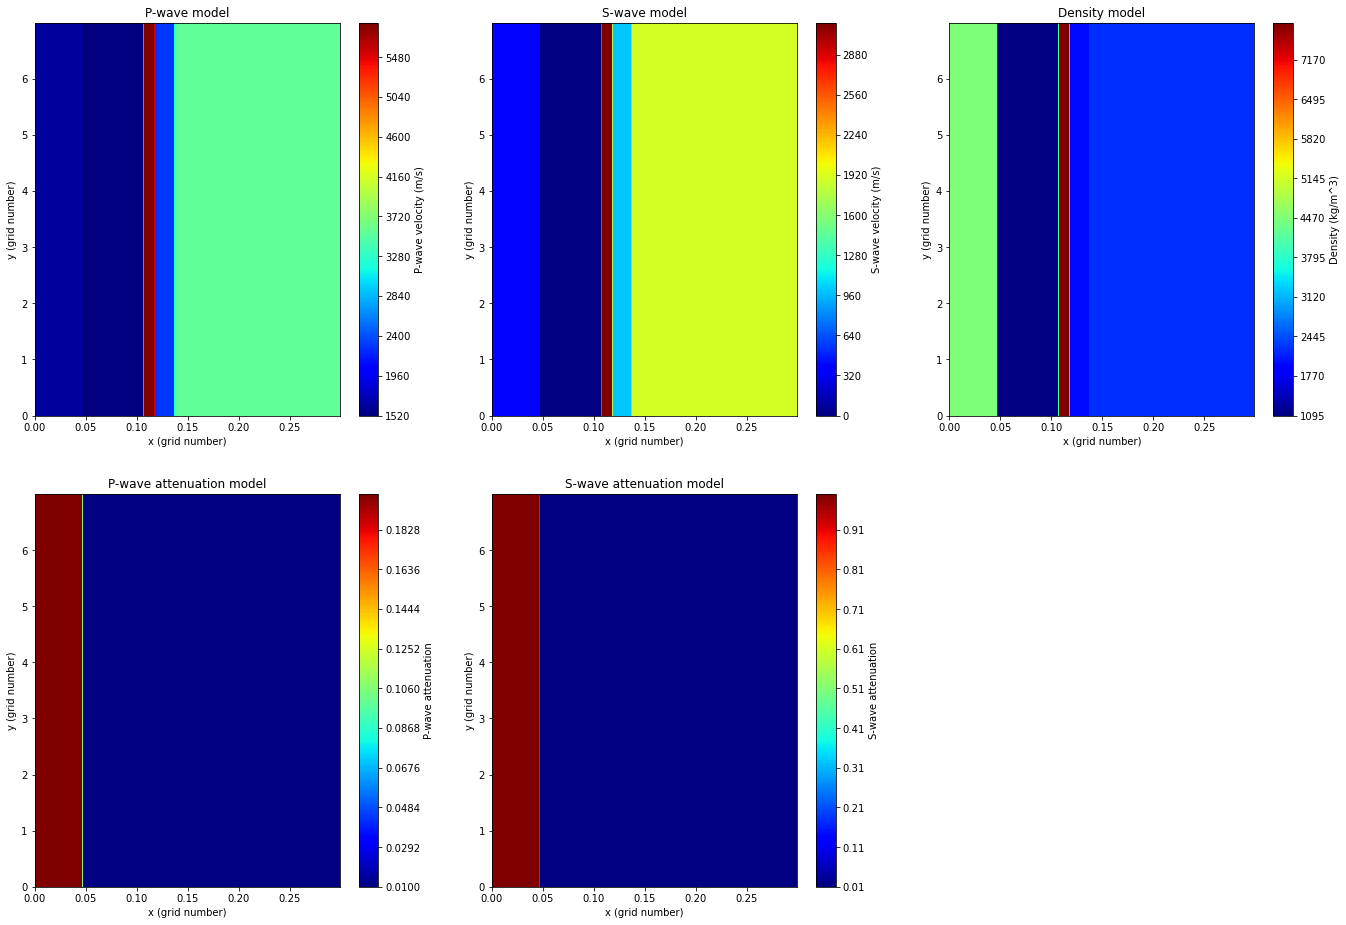

In [107]:
plotmodels(xx_m.T,yy_m.T,zz_Vp,zz_Vs,zz_Rho,zz_Qp,zz_Qs)

### 3. Exporting the models
Each model is imported as a different file with extension .vp, .vs, .rho, .qp, and .qs for P-wave velocity, S-wave velocity, Density, P-wave attenuation, and S-wave attenuation, respectively

In [108]:
os.chdir("C:/Users/Gabinni/Documents/SOFI2D") 

In [109]:
savefile_fromfloat32arraytobinary('test.vp',NX,NY,zz_Vp.astype('float32'))
savefile_fromfloat32arraytobinary('test.vs',NX,NY,zz_Vs.astype('float32'))
savefile_fromfloat32arraytobinary('test.rho',NX,NY,zz_Rho.astype('float32'))
savefile_fromfloat32arraytobinary('test.qp',NX,NY,zz_Qp.astype('float32'))
savefile_fromfloat32arraytobinary('test.qs',NX,NY,zz_Qs.astype('float32'))

### 4. Designing of JSON parameter file
Along this section I interactively set up json file parameters, as described in the SOFI2D guide.

#### 4.1 Domain

SOFI2D allows for multiprocessor processing by dividing the domain into subgrids.
The total number of processors must be specified when starting the program, defining NP:

mpirun - np <NP> ../bin/sofi2D < sofi2D.json
                                            
Parameters are:
- NPROCX : number of processors in x-direction
- NPROCY : number of processors in y-direction

If the total number of processors in sofi2D.json (calculated as NPROCX*NPROCY) and the command line differ the program will terminate with an error message

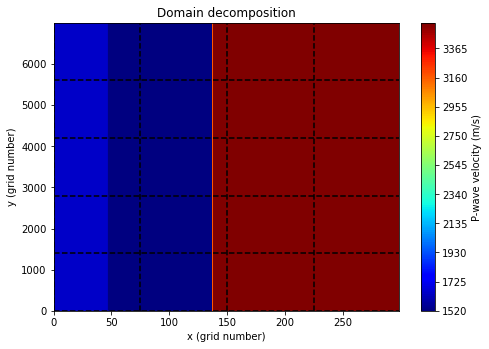

In [11]:
NPROCX=4
NPROCY=5

stepx=NX/NPROCX
stepy=NY/NPROCY

im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.title('Domain decomposition')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")
for n in range(NPROCX):
    plt.plot([n*stepx,n*stepx],[0,NY-1],'black',linestyle='dashed')
for m in range(NPROCY):
    plt.plot([0,NX-1],[m*stepy,m*stepy],'black',linestyle='dashed')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1, wspace=0.2, hspace=0.2)

##### JSON File

In [12]:
jsonfile = open("sofi2D.json", "w")
jsonfile.write('{')
line1=('"Domain Decomposition":"comment",')
line2=('"NPROCX":"'+str(NPROCX)+'",')
line3=('"NPROCY":"'+str(NPROCY)+'",')
jsonfile.write('\n{}\n{}\n{}\n'.format(line1,line2,line3))

63

#### 4.2 Order of the FD Operator
In this step I define the order of the FD operator.
This section is related to section 1., where I defined the grid based on Taylor and Holberg operators.
Parameters are:
- FDORDER:Order of ssg FD coefficients (values: 2, 4, ..., 12)
- FDORDER_TIME: Order of temporal FD coefficients (values: 2 and 4)
- MAXRELERROR: Maximum relative group velocity error E and minimum number of grid points per shortest wavelengths where:
      - 0 --> Taylor coefficients
      - 1 --> Holberg coefficients
      - E=0.5%
      - E=1.0%
      - E=3.0%

In [13]:
FDORDER=12
FDORDER_TIME=4
MAXRELERROR=0

##### JSON File Update

In [14]:
line1=('"FD order":"comment",')
line2=('"FDORDER":"'+str(FDORDER)+'",')
line3=('"FDORDER_TIME":"'+str(FDORDER_TIME)+'",')
line4=('"MAXRELERROR":"'+str(MAXRELERROR)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4))

78

#### 4.3 Discretization
This step import parameters from sections 1 and 2 and checks stability.
Outputs are the initial parameters we defined first:
- NX: number of grid points in the x-direction
- NY: number of grid points in the y-direction
- DH: distance between grid points

I repeat the same stability check than the one performed by the code.

In [15]:
print('Grid has the following dimensions. X:'+str(np.round(NX))+',Y:'+str(np.round(NY))+' with a grid distance '+str(np.round(dh_model,decimals=5)))
vmin=1000
fc=MaxFrequency
N=12
dh_min=np.round(vmin/(fc*N),decimals=5)
print('Minimum grid size required for stability: '+str(dh_min)+' vs '+str(dh_model))

Grid has the following dimensions. X:300,Y:7000 with a grid distance 0.001
Minimum grid size required for stability: 0.02083 vs 0.001


##### JSON Update

In [16]:
line1=('"2-D Grid":"comment",')
line2=('"NX":"'+str(NX)+'",')
line3=('"NY":"'+str(NY)+'",')
line4=('"DH":"'+str(dh_model)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4))

62

#### 4.4 Time stepping
This step i double check that my time stepping is compliant with the minimum value
Parameters are:
- TIME: Experiment time
- DT: Time stepping interval

In [17]:
h_value=h_Taylor_N2[0]
vmax=3544
dt_min_N2=np.round(dh_model/(h_value*np.sqrt(2)*vmax),decimals=9)
dt_min_N4=np.round(6*dh_model/(7*h_value*np.sqrt(2)*vmax),decimals=9)
print('Minimum step size required for stability: '+str(dt_min_N2)+' vs '+str(dt_model)+' for FDORDER_TIME=2')
print('Minimum step size required for stability: '+str(dt_min_N4)+' vs '+str(dt_model)+' for FDORDER_TIME=4')

Minimum step size required for stability: 2e-07 vs 2.514e-06 for FDORDER_TIME=2
Minimum step size required for stability: 1.71e-07 vs 2.514e-06 for FDORDER_TIME=4


##### JSON Update

In [18]:
line1=('"Time Stepping":"comment",')
line2=('"TIME":"'+str(T_length)+'",')
line3=('"DT":"'+str(dt_model)+'",')
jsonfile.write('\n{}\n{}\n{}\n'.format(line1,line2,line3))

63

#### 4.5 Source
In this section I define the shape, source type and location of sources.
Parameters are:
- SOURCE_SHAPE: Shape of source signal (Ricker=1, Fumue=2, using SIGNAL_FILE=3, sinus^3=4)
- SOURCE_TYPE: Point source (explosive=1, force in x=2, force in y=3)
- PLANE_WAVE_DEPTH: Depth of plane wave excitation in meters (if no=0)
- PLANE_WAVE_ANGLE: Dip of plane wave from vertical (in deg)
- TS: Duration of source signal
- SIGNAL_FILE: External signal file name
- SRCREC: Read source positions from external SOURCE_FILE (yes=1)
- SOURCE_FILE: File with source locations
- RUN_MULTIPLE_SHOTS: Multiple shots modeled simultaneously (0) or individually (1)

I subdivide this interval into Source Shape and Source Type/Location sections

##### Source Shape
Along this section I define the source shape. In case I use a plane wave, then SOURCE_SHAPE applies to the experiment, otherwise it is defined for each source in the source file.


597
2.514e-06 2.514e-06


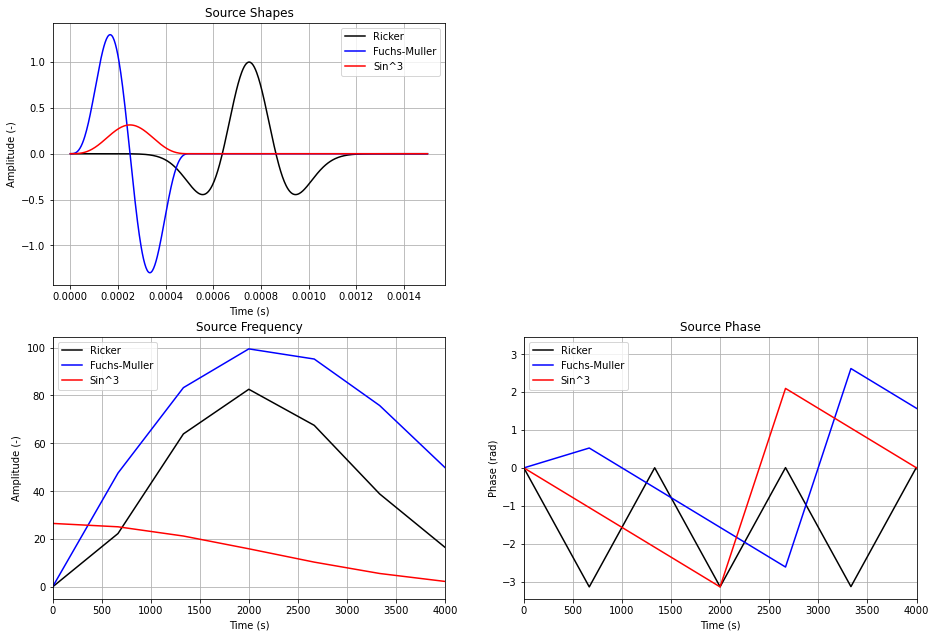

In [53]:
#Source shapes
TS=1.5/1000                #Duration of source signal (s)
FC=2000                #Central frequency (Hz)
TD=0/1000                #Time delay (s)
#Defining the time vector
t=np.arange(0,TS,dt_model)
dt_modelplot=dt_model
# t=np.linspace(0,(2**8-1)*dt_modelplot,2**8)
print(len(t))
print(dt_modelplot,(t[1]-t[0]))
#Ricker wavelet
tau=np.pi*(t-1.5/FC-TD)/(1/FC)
r=(1-2*tau**2)*np.exp(-tau**2)
#Fuchs-Muller wavelet
fm=np.zeros(len(t))
scube=np.zeros(len(t))
for n in range(len(t)):
    if n*dt_modelplot>=TD and n*dt_modelplot<=TD+1/FC:
        fm[n]=np.sin(2*np.pi*(n*dt_modelplot-TD)*FC)-0.5*np.sin(4*np.pi*(n*dt_modelplot-TD)*FC)
    else:
        fm[n]=0
#Sin^3 wavelet
for n in range(len(t)):
    if n*dt_modelplot>=TD and n*dt_modelplot<=TD+1/FC:
        scube[n]=0.00005*np.pi*FC*(np.sin(np.pi*(n*dt_modelplot-TD)*FC))**3
    else:
        scube[n]=0

f_x=fftshift(fftfreq(len(t),d=dt_modelplot))
fft_r=fftshift(fft(r))
f_r_amp=np.abs(fft_r)
f_r_phase=np.angle(fft_r)
fft_fm=fftshift(fft(fm))
f_fm_amp=np.abs(fft_fm)
f_fm_phase=np.angle(fft_fm)
fft_scube=fftshift(fft(scube))
f_scube_amp=np.abs(fft_scube)
f_scube_phase=np.angle(fft_scube)

plt.subplot(221)
plt.plot(t,r,'black',label='Ricker')
plt.plot(t,fm,'blue',label='Fuchs-Muller')
plt.plot(t,scube,'red',label='Sin^3')
plt.legend(); plt.grid()
plt.title('Source Shapes')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (-)')
plt.subplot(223)
plt.plot(f_x,f_r_amp,'black',label='Ricker')
plt.plot(f_x,f_fm_amp,'blue',label='Fuchs-Muller')
plt.plot(f_x,f_scube_amp,'red',label='Sin^3')
plt.legend(); plt.grid()
plt.title('Source Frequency')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude (-)')
plt.xlim(0,MaxFrequency)
plt.subplot(224)
plt.plot(f_x,f_r_phase,'black',label='Ricker')
plt.plot(f_x,f_fm_phase,'blue',label='Fuchs-Muller')
plt.plot(f_x,f_scube_phase,'red',label='Sin^3')
plt.legend(); plt.grid()
plt.title('Source Phase')
plt.xlabel('Time (s)'); plt.ylabel('Phase (rad)')
plt.xlim(0,MaxFrequency)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2, top=2, wspace=0.2, hspace=0.2)

In [54]:
SOURCE_SHAPE=1
SIGNAL_FILE='signal_mseis.tz'
SRCREC=1
SOURCE_FILE='./sources/source.dat'
RUN_MULTIPLE_SHOTS=0

##### Source Type/Location
###### Plane wave

Plane waves are generated from a line source defined all along the domain.
In case a plane wave is used, the following parameters are required:
- PLANE_WAVE_DEPTH: Depth of plane wave excitation in meters (if no=0)
- PLANE_WAVE_ANGLE: Dip of plane wave from vertical (in deg)
Also, we recommend to set this parameter:
- SRCREC: Read source positions from external SOURCE_FILE (no=0)

The following code allows to interactively see the location and propagation direction of the plane wave

<ipython-input-55-fba3619ca891>:5: RuntimeWarning: divide by zero encountered in double_scalars
  x_bottom=(Y_length-PLANE_WAVE_DEPTH)/np.tan(PLANE_WAVE_ANGLE*np.pi/180)


OverflowError: cannot convert float infinity to integer

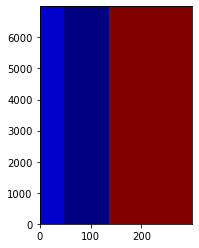

In [55]:
PLANE_WAVE_DEPTH=0                       #in m
PLANE_WAVE_ANGLE=0                       #in deg
# TS=0.2
#The line source is defined as a slope y=a+bx where a=PLANE_WAVE_DEPTH and b=tan(PLANE_WAVE_ANGLE)
x_bottom=(Y_length-PLANE_WAVE_DEPTH)/np.tan(PLANE_WAVE_ANGLE*np.pi/180)

plt.subplot(1,2,1)
im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.plot([0,int(np.round(x_bottom/dh_model))],[int(np.round(PLANE_WAVE_DEPTH/dh_model)),int(np.round(Y_length/dh_model))],'red',label='Plane wave source')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Line')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

y_source=np.linspace(0,NY-1,NY-1)
x_source=np.linspace(0,NY-1,NY-1)
for n in range(NY-1):
    x_source[n]=int(np.round((NY-int(np.round(PLANE_WAVE_DEPTH/dh_model)))/np.tan(PLANE_WAVE_ANGLE*np.pi/180)/dh_model))
plt.subplot(1,2,2)
im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(x_source,y_source, color='black',label='Source Location')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Grid')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.2, hspace=0.2)

##### Point sources
In this section I generate a single set of point sources defined from a line vector.
This definition requires the generation of an ASCII file (SOURCE_FILE). In the JSON file, the following parameters are required:
- PLANE_WAVE_DEPTH: 0 (Recommended)
- SRCREC: 1
- SOURCE_FILE: './sources/source.dat'

SOURCE_FILE parameters are:
- XSRC: x-coordinate of a source point (in m)
- YSRC: y-coordinate of a source point (in m)
- TD: excitation time-delay for the source point (in s)
- FC: center frequency of the source signal (in Hz)
- AMP: maximum amplitude of the source signal
- SOURCE_AZIMUTH (Optional): angle between y- and x- direction (activated if SOURCE_TYPE=4)
- SOURCE_TYPE (Optional): source type (explosive=1, force in x=2, force in y=3, SOURCE_AZIMUTH=4). If this value is set, SOURCE_TYPE in here overrides SOURCE_TYPE from the JSON file




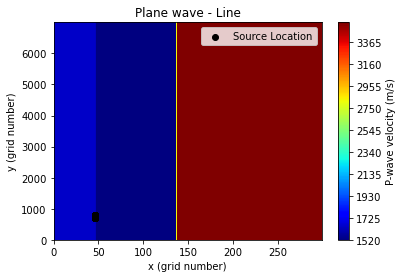

In [56]:
#Define coordinates for source
SourceFileinput=np.zeros([0,7])
#Source set 1
x_start=0.046
x_end=0.046
y_start=0.7
y_end=0.8
spacing=0.0002
TD=0/10000
FC=2000
AMP=1
SOURCE_AZIMUTH=0
SOURCE_TYPE=1

Array_raw=LinearArray(x_start,x_end,y_start,y_end,spacing)
Array=TRplacement(dh_model,0,0,Array_raw)
Source_addon=np.zeros([len(Array),7])
for n in range(len(Array)):
    Source_addon[n,0]=Array[n,0]
    Source_addon[n,1]=Array[n,1]
    Source_addon[n,2]=TD
    Source_addon[n,3]=FC
    Source_addon[n,4]=AMP
    Source_addon[n,5]=SOURCE_AZIMUTH
    Source_addon[n,6]=SOURCE_TYPE
SourceFileinput=np.vstack((SourceFileinput,Source_addon))
#Source set 2
# for n in range(len(Array)):
#     Source_addon[n,0]=Array[n,0]-dh_model
#     Source_addon[n,1]=Array[n,1]-dh_model
#     Source_addon[n,2]=TD
#     Source_addon[n,3]=FC
#     Source_addon[n,4]=-AMP
#     Source_addon[n,5]=SOURCE_AZIMUTH
#     Source_addon[n,6]=SOURCE_TYPE
# SourceFileinput=np.vstack((SourceFileinput,Source_addon))

im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(SourceFileinput[:,0]/dh_model,SourceFileinput[:,1]/dh_model, color='black',label='Source Location')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Line')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

##### Writing SOURCEFILE

In [57]:
Decimals=5
file=open('source.dat','w')
for n in range(len(SourceFileinput)):
    file.write('{} {} {} {} {} {} {}\n'.format(np.round(SourceFileinput[n,0],decimals=Decimals),np.round(SourceFileinput[n,1],decimals=Decimals),np.round(SourceFileinput[n,2],decimals=Decimals),np.round(SourceFileinput[n,3],decimals=Decimals),np.round(SourceFileinput[n,4],decimals=Decimals),np.round(SourceFileinput[n,5],decimals=Decimals),np.round(SourceFileinput[n,6],decimals=Decimals)))
file.close()

In [58]:
file=open('source.dat','r')
print(file.read())

0.046 0.699 0.0 2000.0 1.0 0.0 1.0
0.046 0.7 0.0 2000.0 1.0 0.0 1.0
0.046 0.701 0.0 2000.0 1.0 0.0 1.0
0.046 0.702 0.0 2000.0 1.0 0.0 1.0
0.046 0.703 0.0 2000.0 1.0 0.0 1.0
0.046 0.704 0.0 2000.0 1.0 0.0 1.0
0.046 0.705 0.0 2000.0 1.0 0.0 1.0
0.046 0.706 0.0 2000.0 1.0 0.0 1.0
0.046 0.707 0.0 2000.0 1.0 0.0 1.0
0.046 0.708 0.0 2000.0 1.0 0.0 1.0
0.046 0.709 0.0 2000.0 1.0 0.0 1.0
0.046 0.71 0.0 2000.0 1.0 0.0 1.0
0.046 0.711 0.0 2000.0 1.0 0.0 1.0
0.046 0.712 0.0 2000.0 1.0 0.0 1.0
0.046 0.713 0.0 2000.0 1.0 0.0 1.0
0.046 0.714 0.0 2000.0 1.0 0.0 1.0
0.046 0.715 0.0 2000.0 1.0 0.0 1.0
0.046 0.716 0.0 2000.0 1.0 0.0 1.0
0.046 0.717 0.0 2000.0 1.0 0.0 1.0
0.046 0.718 0.0 2000.0 1.0 0.0 1.0
0.046 0.719 0.0 2000.0 1.0 0.0 1.0
0.046 0.72 0.0 2000.0 1.0 0.0 1.0
0.046 0.721 0.0 2000.0 1.0 0.0 1.0
0.046 0.722 0.0 2000.0 1.0 0.0 1.0
0.046 0.723 0.0 2000.0 1.0 0.0 1.0
0.046 0.724 0.0 2000.0 1.0 0.0 1.0
0.046 0.725 0.0 2000.0 1.0 0.0 1.0
0.046 0.726 0.0 2000.0 1.0 0.0 1.0
0.046 0.727 0.0 2000.0 1

In [25]:
line1=('"Sources":"comment",')
line2=('"SOURCE_SHAPE":"'+str(SOURCE_SHAPE)+'",')
line3=('"SIGNAL_FILE":"'+str(SIGNAL_FILE)+'",')
line4=('"SOURCE_TYPE":"'+str(SOURCE_TYPE)+'",')
line5=('"SRCREC":"'+str(SRCREC)+'",')
line6=('"SOURCE_FILE":"'+str(SOURCE_FILE)+'",')
line7=('"RUN_MULTIPLE_SHOTS":"'+str(RUN_MULTIPLE_SHOTS)+'",')
line8=('"PLANE_WAVE_DEPTH":"'+str(PLANE_WAVE_DEPTH)+'",')
line9=('"PLANE_WAVE_ANGLE":"'+str(PLANE_WAVE_ANGLE)+'",')
line10=('"TS":"'+str(TS)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4,line5,line6,line7,line8,line9,line10))

235

#### 4.6 Generation of models
In this section I choose the input models. In case I use the models designed before in Section 2, then READMOD=1
Parameters are:
- READMOD: read model parameter from MFILE (Yes=1)
- MFILE: String for model file names
- WRITE_MODELS: Switch to decide if models are written to file (No model=0, all models=1, only density=2)

In [26]:
READMOD=1
MFILE='model/test'
WRITE_MODELFILES=1

##### JSON Update

In [27]:
line1=('"Model Generation":"comment",')
line2=('"READMOD":"'+str(READMOD)+'",')
line3=('"MFILE":"'+str(MFILE)+'",')
line4=('"WRITE_MODELFILES":"'+str(WRITE_MODELFILES)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4))

92

#### 4.7 Q-approximation
This section is to choose whether the model behaves as an elastic or viscoelastic model.
Parameters are:
- L: Number of relaxation mechanisms (elastic=0, >0 viscoelastic)
- FLn: Relaxation frequency (one for each relaxation mechanism)
- TAU: T-> check Bohlen 2002

In [29]:
L=0
FL1=4000
TAU=0

##### JSON Update

In [30]:
line1=('"Q-Approximation":"comment",')
line2=('"L":"'+str(L)+'",')
line3=('"FL1":"'+str(FL1)+'",')
line4=('"TAU":"'+str(TAU)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4))

64

#### 4.8 Boundary conditions
In this section I update the set up for boundary conditions. There are two options: CPML-Boundary and Damping-Boundary, each one with its own set of parameters.
Parameters are:
- FREE-SURF: free surface at the top of the model (Yes=1)
- BOUNDARY: apply periodic boundary condition at edges (no=0, left and right=1)
- FW: width of absorbing frame (in gridpoints, no=0)
- ABS_TYPE: Type of absorbing boundary (CPML-Boundary=1, Damping-Boundary=2)
For CPML-Boundary (ABS_TYPE=1) --> recommended width: 10-20 grid points
- NPOWER: Check references
- K_MAX_CPML: Check references
- VPPML: approximately propagation velocity near borders
- FPML: aproximately dominant frequency at borders
For Damping-Boundary (ABS_TYPE=2) --> recommended width: >20 grid points
- DAMPING: percentual factor per grid

In [31]:
FREE_SURF=0
BOUNDARY=0
FW=35
ABS_TYPE=2
NPOWER= 4
K_MAX_CPML=1
VPPML=3048
FPML=8603
DAMPING=8

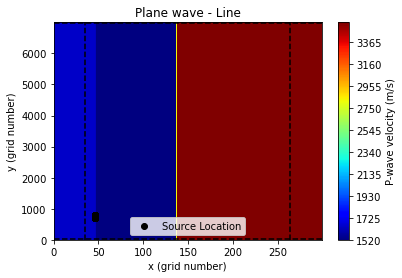

In [32]:
im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(SourceFileinput[:,0]/dh_model,SourceFileinput[:,1]/dh_model, color='black',label='Source Location')
plt.plot([0,NX-1],[FW,FW],'black',linestyle='dashed')
plt.plot([0,NX-1],[NY-FW-1,NY-FW-1],'black',linestyle='dashed')
plt.plot([FW,FW],[0,NY-1],'black',linestyle='dashed')
plt.plot([NX-FW-1,NX-FW-1],[0,NY-1],'black',linestyle='dashed')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Line')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

##### JSON Update

In [33]:
line1=('"Boundary Conditions":"comment",')
line2=('"FREE_SURF":"'+str(FREE_SURF)+'",')
line3=('"BOUNDARY":"'+str(BOUNDARY)+'",')
line4=('"FW":"'+str(FW)+'",')
line5=('"ABS_TYPE":"'+str(ABS_TYPE)+'",')
line6=('"NPOWER":"'+str(NPOWER)+'",')
line7=('"K_MAX_CPML":"'+str(K_MAX_CPML)+'",')
line8=('"VPPML":"'+str(VPPML)+'",')
line9=('"FPML":"'+str(FPML)+'",')
line10=('"DAMPING":"'+str(DAMPING)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4,line5,line6,line7,line8,line9,line10))

172

#### 4.9 Wavefield snapshots
In this section I set up what snapshots I want.
Parameters are:
- SNAP: Output type (no seismograms=0, particle-velocities=1, pressure field=2, curl and divergence energy=3, velocities, pressure and energy=4)
- TSNAP: first snapshot (in s)
- TSNAP: last snapshot (in s)
- TSNAPINC: increment (in s)
- IDX: increment x-direction (in grid points) -> higher values smaller resolution
- IDY: increment y-direction (in grid points) -> higher values smaller resolution
- SNAP_FORMAT: data format (ASCII=2, BINARY=3)
- SNAP_FILE: snap filename

In [34]:
SNAP=4
TSNAP1=T_length/50
TSNAP2=T_length
TSNAPINC=T_length/50
IDX=25
IDY=25
SNAP_FORMAT=3
SNAP_FILE='./snap/test'

##### JSON Update

In [35]:
line1=('"Wavefield Snapshots":"comment",')
line2=('"SNAP":"'+str(SNAP)+'",')
line3=('"TSNAP1":"'+str(TSNAP1)+'",')
line4=('"TSNAP2":"'+str(TSNAP2)+'",')
line5=('"TSNAPINC":"'+str(TSNAPINC)+'",')
line6=('"IDX":"'+str(IDX)+'",')
line7=('"IDY":"'+str(IDY)+'",')
line8=('"SNAP_FORMAT":"'+str(SNAP_FORMAT)+'",')
line9=('"SNAP_FILE":"'+str(SNAP_FILE)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4,line5,line6,line7,line8,line9))

207

#### 4.10 Receivers
I design the receivers set as an array of receivers. If I want to a 'single receiver', I put a continuous line of receivers placed from a start to an end. If I want multiple receivers, I used the x and y start points for the first receivers and then I add another receiver at a specific distance.
Parameters are:
- SEISMO: output of seismograms (no seismograms=0, particle-velocities=1, pressure (hydrphone)=2, curl and dive=3, everything= 4)
- READREC: Read receiver positions from file (Yes=1). If Yes, then XREC1, YREC1, XREC2, YREC2, and NGEOPH are ignored
- REC_FILE: External receiver file name
- REFREC: Reference point for receiver coordinate system
- XREC1, YREC1: position of first receiver (in m)
- XREC2, YREC2: position of last receiver (in m)
- NGEOPH: distance between two adjacent receivers (in gridpoints)

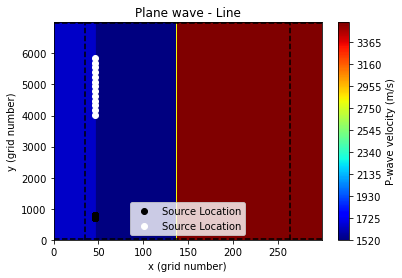

In [36]:
#Define coordinates for source
ReceiverFileinput=np.zeros([0,2])
#Receiver set 1
x_start=0.046
x_end=0.046
y_start=4.0266
y_end=6.01

ReqReceivers=8
DistStarttoEnd=np.sqrt((x_end-x_start)**2+(y_end-y_start)**2)
DistReceivers_m=DistStarttoEnd/ReqReceivers

spacing=0.1524

Array_raw=LinearArray(x_start,x_end,y_start,y_end,spacing)
Array=TRplacement(dh_model,0,0,Array_raw)
Receiver_addon=np.zeros([len(Array),2])
for n in range(len(Array)):
    Receiver_addon[n,0]=Array[n,0]
    Receiver_addon[n,1]=Array[n,1]
ReceiverFileinput=np.vstack((ReceiverFileinput,Receiver_addon))


im1 = plt.contourf(xx_grid.T, yy_grid.T, zz_Vp,500,cmap=plt.cm.jet,norm=None)
plt.scatter(SourceFileinput[:,0]/dh_model,SourceFileinput[:,1]/dh_model, color='black',label='Source Location')
plt.scatter(ReceiverFileinput[:,0]/dh_model,ReceiverFileinput[:,1]/dh_model, color='white',label='Source Location')
plt.plot([0,NX-1],[FW,FW],'black',linestyle='dashed')
plt.plot([0,NX-1],[NY-FW-1,NY-FW-1],'black',linestyle='dashed')
plt.plot([FW,FW],[0,NY-1],'black',linestyle='dashed')
plt.plot([NX-FW-1,NX-FW-1],[0,NY-1],'black',linestyle='dashed')
plt.xlim(0,NX-1) ; plt.ylim(0,NY-1)
plt.legend()
plt.title('Plane wave - Line')
plt.xlabel('x (grid number)'); plt.ylabel('y (grid number)')
cbar = plt.colorbar(im1, orientation = 'vertical')
cbar.set_label("P-wave velocity (m/s)")

In [37]:
SEISMO=2
READREC=1
REC_FILE='./receiver/receiver.dat'
REFREC_TUPLE=str(0)+' , '+str(0)
REC1_TUPLE=str(x_start)+' , '+str(y_start)
REC2_TUPLE=str(x_end)+' , '+str(y_end)
NGEOPH=27

In [38]:
Decimals=5
file=open('receiver.dat','w')
for n in range(len(ReceiverFileinput)):
    file.write('{} {}\n'.format(np.round(ReceiverFileinput[n,0],decimals=Decimals),np.round(ReceiverFileinput[n,1],decimals=Decimals)))

In [39]:
file=open('receiver.dat','r')
print(file.read())

0.046 4.026
0.046 4.179
0.046 4.331
0.046 4.483
0.046 4.636
0.046 4.788
0.046 4.941
0.046 5.093
0.046 5.245
0.046 5.398
0.046 5.55
0.046 5.703
0.046 5.855



##### JSON Update

In [40]:
line1=('"Receivers":"comment",')
line2=('"SEISMO":"'+str(SEISMO)+'",')
line3=('"READREC":"'+str(READREC)+'",')
line4=('"REC_FILE":"'+str(REC_FILE)+'",')
line5=('"REFRECX, REFRECY":"'+str(REFREC_TUPLE)+'",')
line6=('"XREC1, YREC1":"'+str(REC1_TUPLE)+'",')
line7=('"XREC2, YREC2":"'+str(REC2_TUPLE)+'",')
line8=('"NGEOPH":"'+str(NGEOPH)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4,line5,line6,line7,line8))

198

#### 4.11 Receiver array
In case I want horizontal set of receivers, I can set up this option on.
Parameters are:
- REC_ARRAY: number of horizontal receiver arrays simulated. (No=0)
- REC_ARRAY_DEPTH: depth of the first array (in m)
- REC_ARRAY_DIST: vertical distance between arrays (in m)
- DRX: distance between receivers for each horizontal array (in grid points)

In [41]:
REC_ARRAY=0
REC_ARRAY_DEPTH=70
REC_ARRAY_DIST=40
DRX=4

##### JSON Update

In [42]:
line1=('"Receivers array":"comment",')
line2=('"REC_ARRAY":"'+str(REC_ARRAY)+'",')
line3=('"REC_ARRAY_DEPTH":"'+str(REC_ARRAY_DEPTH)+'",')
line4=('"REC_ARRAY_DIST":"'+str(REC_ARRAY_DIST)+'",')
line5=('"DRX":"'+str(DRX)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4,line5))

105

#### 4.12 Seismograms
In this step, I set up the format and location of output waveforms at each receiver.
Parameters are:
- NDT: sampling rate (in time steps)
- SEIS_FORMAT: data output format (SU format=1, TEXTUAL -native ASCII- =2,BINARY -IEEE-4-bytes-float-=3)
- SEIS_FILE: basic filename

In [43]:
NDT=1
SEIS_FORMAT=2
SEIS_FILE='./su/test'

##### JSON Update

In [44]:
line1=('"Seismograms":"comment",')
line2=('"NDT":"'+str(NDT)+'",')
line3=('"SEIS_FORMAT":"'+str(SEIS_FORMAT)+'",')
line4=('"SEIS_FILE":"'+str(SEIS_FILE)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4))

81

#### 4.13 Monitoring the simulation
In this step I setup the amount of information I obtain in order to control the simulation.
Parameters are:
- LOG: output of logging information of node (no output=0, to stdout=1, to file LOG_FILE=2)
- LOG_FILE: log file name to output the monitoring info
- OUT_TIMESTEP_INFO: time between monitoring outputs

In [45]:
LOG=1
LOG_FILE='log/test.log/'
OUT_TIMESTEP_INFO=1000

##### JSON Update

In [46]:
line1=('"Monitoring":"comment",')
line2=('"LOG_FILE":"'+str(LOG_FILE)+'",')
line3=('"LOG":"'+str(LOG)+'",')
line4=('"OUT_TIMESTEP_INFO":"'+str(OUT_TIMESTEP_INFO)+'",')
jsonfile.write('\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4))

92

#### 4.14 Checkpointing
If I want to generate checkpoints and continue from an specific point since I interrupted my processing, I can set up this parameters. They can generate a huge amount of data!
Parameters are:
- CHECKPTREAD: read wavefield from checkpoint file (yes=1, no=0)
- CHECKPTWRITE: write wavefield to checkpoint file (yes=1, no=0)
- CHECKPTFILE: checkpoint filename

In [47]:
CHECKPTREAD=0
CHECKPTWRITE=0
CHECKPT_FILE='tmp/checkpoint_sofi2D'

##### JSON Update

In [48]:
line1=('"Checkpointing":"comment",')
line2=('"CHECKPTREAD":"'+str(CHECKPTREAD)+'",')
line3=('"CHECKPTWRITE":"'+str(CHECKPTWRITE)+'",')
line4=('"CHECKPT_FILE":"'+str(CHECKPT_FILE)+'",')
line5=('}')
jsonfile.write('\n{}\n{}\n{}\n{}\n{}\n'.format(line1,line2,line3,line4,line5))
jsonfile.close()

#### 4.15 JSON File Preview

In [49]:
jsonfile = open("sofi2D.json", "r")
print(jsonfile.read())

{
"Domain Decomposition":"comment",
"NPROCX":"4",
"NPROCY":"5",

"FD order":"comment",
"FDORDER":"12",
"FDORDER_TIME":"4",
"MAXRELERROR":"0",

"2-D Grid":"comment",
"NX":"300",
"NY":"7000",
"DH":"0.001",

"Time Stepping":"comment",
"TIME":"0.0055",
"DT":"2.514e-06",

"Sources":"comment",
"SOURCE_SHAPE":"1",
"SIGNAL_FILE":"signal_mseis.tz",
"SOURCE_TYPE":"1",
"SRCREC":"1",
"SOURCE_FILE":"./sources/source.dat",
"RUN_MULTIPLE_SHOTS":"0",
"PLANE_WAVE_DEPTH":"0",
"PLANE_WAVE_ANGLE":"0",
"TS":"0.0007",

"Model Generation":"comment",
"READMOD":"1",
"MFILE":"model/test",
"WRITE_MODELFILES":"1",

"Q-Approximation":"comment",
"L":"0",
"FL1":"4000",
"TAU":"0",

"Boundary Conditions":"comment",
"FREE_SURF":"0",
"BOUNDARY":"0",
"FW":"35",
"ABS_TYPE":"2",
"NPOWER":"4",
"K_MAX_CPML":"1",
"VPPML":"3048",
"FPML":"8603",
"DAMPING":"8",

"Wavefield Snapshots":"comment",
"SNAP":"4",
"TSNAP1":"0.00010999999999999999",
"TSNAP2":"0.0055",
"TSNAPINC":"0.00010999999999999999",
"IDX":"25",
"IDY":"25",
"SNAP_FOR

### 5. Next Steps

#### 5.1 Generated input files and location
We describe the generated files, function and location within the /SOFI2D/par/ folder
- JSON file (sofi2D.json)--> Parameters --> ./in_and_out/
- VP, VS, RHO, QP and QS models (test.vp, test.vs, test.rho, test.qp, test.qs) --> Mechanical properties models --> ./model/
- SOURCES file (source.dat) --> Sources' location and parameters --> ./sources/
- RECEIVERS file (receiver.dat) --> Receiver's location

#### 5.2 Model QC
After moving the model files to SOFI2D/model/ folder, we can check the model structure using the command ximage.
Using this command before executing the files helps QCing input files.
Execute for (each) one of the input model files (from SOFI2D/par/ directory):
ximage n1=NY n2=NX < model/.test.vp

#### 5.3 Compilation of sofi2D
This is located and run in folder SOFI2D/src/
This can be done once, unless you change something within the parametrical modeling files.
- MODEL_V=hh_visco.c --> viscoelastic model (L>0)
- MODEL_E=hh_elastic.c --> elastic model (L=0)
- Overnight builts (not developed here)
Within src directory, execute either make all or make sofi2D (snapmerge will be also generated)

#### 5.4 Running the program
Running the program is started from the folder SOFI2D/par/
Running has the following structure:
    mpirun -np 1 nice -19 ../bin/sofi2D ./in_and_out/sofi2D.json | tee ./in_and_out/sofi2D.jout
where:
- mpirun is the executing command
- -np is the number of processors we are using (if it is not equal to the one in sofi2D.json, the program will abort)
- nice -19 is the priority index (-19 allows to process sofi2D in background and using the computer while processing)
- ../bin/sofi2D is the compiled file (from 5.2)
- ./in_and_out/sofi2D.json is the parameters file
- | tee ./in_and_out/sofi2D.jout is the request to generate a report file called sofi2D.jout

Once executed, the model will show sofi2d.json parameters in a table and start working. For each parameters, it will QC whether the parameter is correct (or not) and briefly explain its implications within processing. In most cases, if a parameter is not correct (wrong input), the process will terminate and a message error will show the parameter causing the issue.

#### 5.5 Processing results - Output files and location
After execution of the script, multiple files will be generated, depending on the JSON file parameters.
We will enumerate files, structure and location of each output file:

##### 5.5.a Report File
This file writes down onscreen report shown when running the program.
It will be written if, when running the program, "| tee ./in_and_out/sofi2D.jout" was written.
Location of this file is ./in_and_out/
Format of the file is ASCII, can be opened as text

##### 5.5.b Models
These files replicate the input model we used during processing.
It will be written if the JSON parameter WRITE_MODELFILES is equal to 1 or 2. If equal to 1, then it will output all models Rho, U, Pi and Taup and Taus. If equal to 2, only density model Rho.
Location of these files is ./model/
File naming depends on the number of processors  used:
- Files start with: test.SOFI2D.property (pi, rho, u, vp, vs)
- Files have names based on how processors are distributed, assuming a grid with defined by arrays 0 to NX and 0 to NY
- For example, the Vp model used in the segment taken by Processor number 4 (in NX=NY=2) is shown as: test.SOFI2D.vp.1.1
Format of the file is binary.

##### 5.5.c Wavefield snapshots
These files replicate spatial seismograms during processing.
It will be written if the JSON parameter SNAP is equal to 1, 2, 3 or 4. If equal to 1 the output is only particle velocities; if equal to 2, is the pressure field; if 3, curl and divergence energy; and if 4, all 1,2 and 3.
Location of these files is ./snap/
File naming depends on the number of processors  used:
- Files start with: test.bin/txt.property (vx, vy, p, div, curl)
- Files have names based on how processors are distributed, assuming a grid with defined by arrays 0 to NX and 0 to NY
- For example, the Vp model used in the segment taken by Processor number 4 (in NX=NY=2) is shown as: test.bin.vp.1.1 (if the file is binary)
- A final file containing the simulation within the whole space will have no processor coordinate references
- Each file contains all snapshots in a single file
Format of the files depends on JSON parameter SNAP_FORMAT: if equal to 2, format is ASCII, if equal to 3, then binary

##### 5.5.d Seismograms
These files are the waveforms acquired by each defined receiver.
It will be written if the JSON parameter SEISMO is equal to 1, 2, 3 or 4. If equal to 1 the output is only particle velocities; if equal to 2, is the pressure field; if 3, curl and divergence energy; and if 4, all 1,2 and 3.
Location of these files is ./su/
File naming depends on the number of processors  used:
- Files start with: test_property (vx, vy, p, div, curl)
- Files have names based on how processors are distributed, assuming a grid with defined by arrays 0 to NX and 0 to NY
- For example, the Vp model used in the segment taken by Processor number 4 (in NX=NY=2) is shown as: test_vp.bin.shot1 (when analyzing shot 1 for multiple shots)
- A final file containing the simulation within the whole space will have no processor coordinate references
- If multiple shots were performed, every file will be divided for each shot
Format of the files depends on JSON parameter SEIS_FORMAT: if equal to 1, Seismic Unix format; if 2, format is ASCII, if equal to 3, then binary

